In this project, we will use an RNN architecture to build a Machine Translation model.

It will use as a corpus wikipedia dumps.

Either the source or the target will be English. We will, in our case, try English to French Translation.

In [ ]:
#imports
!pip3 install numpy
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu117
#or any nightly version so long as pytorch > 1.11 https://pytorch.org/
!pip3 install gensim transformers d2l==1.0.0a1.post0

#In pytorch functional.py, change PILLOW_VERSION to __version__
#there are two places to change

Dataset

In [30]:
#Test samples location and preprocessing

#cell almost entirely from https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html
import os
import torch
from d2l import torch as d2l

class MTFraEng(d2l.DataModule):  #@save
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])  # src.append(EOS_token) ? 
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=15, num_train=162000, num_test=4000):  #15, 162000
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())


@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train - self.num_test) if train else slice(self.num_train - self.num_test, self.num_train)
    return self.get_tensorloader(self.arrays, train, idx)

@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

#src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
#print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
#print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

@d2l.add_to_class(MTFraEng)  #@save
def shuffle(self, train, seed, maxi):
    if (maxi > self.num_train):
        raise ValueError("maxi must be less than the length of the dataset")
    
    for array in self.arrays:
        array = array[0:maxi]
        
    self.num_train = maxi
    self.num_test = int(maxi * 0.3)
    
    idx = torch.randperm(generator=torch.Generator().manual_seed(seed), n=maxi)
    if (not train):
        idx = idx[int(maxi * 0.7):]
    else :
        idx = idx[:int(maxi * 0.7)]
    return self.get_tensorloader(self.arrays, train, idx)
    

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
batch_size = 5

data = MTFraEng(batch_size=batch_size)

usage_size = 1000

In [36]:
print(len(data.get_dataloader(train=False)))
print(len(data.get_dataloader(train=True)))
print(len(data.shuffle(train=True, seed=0, maxi=usage_size)))
print(len(data.shuffle(train=False, seed=0, maxi=usage_size)))
print(len(data.get_dataloader(train=False)))
print(len(data.get_dataloader(train=True)))

800
31600
140
60
60
140


Word embedding

# We will use three different types of word embeddings:
# 1. Word2Vec
# 2. GloVe
# 3. FastText


In [5]:
"""## Word2Vec"""
import gensim

In [6]:
#keep in mind you have to launch the notebook inside the git folder to make this work (second one)
from inspect import getsourcefile
import sys
print(os.path.dirname(getsourcefile(lambda:0)))
print(sys.path[0])
print(os.path.abspath(sys.argv[0]))

/tmp/ipykernel_4268
/home/lize/Desktop/MASTER2/Web_Text_Analysis/webtextanalysis
/home/lize/.local/lib/python3.10/site-packages/ipykernel_launcher.py


In [7]:
src, tgt, src_valid_len, label = next(iter(data.shuffle(train=False, seed=0, maxi=1)))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))

source: tensor([[3681,   72,  187,  188,  188,  188,  188,  188,  188,  188,  188,  188,
          188,  188,  188]], dtype=torch.int32)
decoder input: tensor([[  136, 15923,     0,   137,   138,   138,   138,   138,   138,   138,
           138,   138,   138,   138,   138]], dtype=torch.int32)


In [8]:
import numpy as np

def save_split():
    data = MTFraEng(batch_size=5)
    with open("samples/source.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[0][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
    with open("samples/target.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[1][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
def load_source():
    return np.loadtxt("samples/source.txt", dtype=str)

def load_target():
    return np.loadtxt("samples/target.txt", dtype=str)

def word_to_token(word, src=True):
    if src :
        return data.src_vocab[word]
    else :
        return data.tgt_vocab[word]

def token_to_word(token, src=True):
    if src :
        return data.src_vocab.to_tokens(token)
    else :
        return data.tgt_vocab.to_tokens(token)

def test_similarity(model, word1, word2, model_name, src=True):
    print("Cosine similarity between '" + word1 + "' and '"+ word2 +"' - " + model_name + " : " + str(model.similarity(word_to_token(word1, src), word_to_token(word2, src))))


In [9]:
#print a few samples
for i in range(5):
    print(token_to_word(data.arrays[0][i].numpy(), True))

for i in range(5):
    print(token_to_word(data.arrays[1][i].numpy(), False))

['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['run', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['run', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['who', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'salut', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'cours', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [10]:
if not os.path.exists(sys.path[0] + "/samples/source.txt") or not os.path.exists(sys.path[0] + "/samples/target.txt"):
    save_split()

In [11]:

source_text = load_source()
one_line_source = source_text.reshape([np.prod(source_text.shape)])

#format to be accepted by Word2Vec
one_line_source = [str(i).split() for i in one_line_source]

print(one_line_source[:4])
#print in words 
print([token_to_word(int(i[0]), src=True) for i in one_line_source[:4]])



target_text = load_target()
one_line_target = target_text.reshape([np.prod(target_text.shape)])

#format to be accepted by Word2Vec
one_line_target = [str(i).split() for i in one_line_target]

print(one_line_target[:4])
#print in words 
print([token_to_word(int(i[0]), src=False) for i in one_line_target[:4]])

[['3681'], ['72'], ['187'], ['188']]
['go', '.', '<eos>', '<pad>']
[['136'], ['15923'], ['0'], ['137']]
['<bos>', 'va', '!', '<eos>']


In [12]:
"""## Word2Vec"""

print(one_line_source[:5])

if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    # Create CBOW model
    source_w2v_model_cbow = gensim.models.Word2Vec(one_line_source, min_count = 3,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    # Create Skip Gram model
    source_w2v_model_skip = gensim.models.Word2Vec(one_line_source, min_count = 3, vector_size = 100,
                                                window = 5, sg = 1).wv
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    # Create CBOW model
    target_w2v_model_cbow = gensim.models.Word2Vec(one_line_target, min_count = 3,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    # Create Skip Gram model
    target_w2v_model_skip = gensim.models.Word2Vec(one_line_target, min_count = 3, vector_size = 100,
                                                window = 5, sg = 1).wv

[['3681'], ['72'], ['187'], ['188'], ['188']]


In [13]:
#save the models
if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    source_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    source_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    target_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    target_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [14]:
#load the models
source_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
source_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
target_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)
target_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [15]:
test_similarity(source_w2v_model_cbow, 'hi', '.', "CBOW")
test_similarity(source_w2v_model_cbow, 'hi', 'run', "CBOW")

test_similarity(source_w2v_model_skip, 'hi', '.', "SkipGram")
test_similarity(source_w2v_model_skip, 'hi', 'run', "SkipGram")

test_similarity(target_w2v_model_cbow, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_cbow, 'bonjour', 'cours', "CBOW")

test_similarity(target_w2v_model_skip, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_skip, 'bonjour', 'cours', "CBOW")

Cosine similarity between 'hi' and '.' - CBOW : -0.03504046
Cosine similarity between 'hi' and 'run' - CBOW : -0.0359637
Cosine similarity between 'hi' and '.' - SkipGram : -0.03504046
Cosine similarity between 'hi' and 'run' - SkipGram : -0.0359637
Cosine similarity between 'bonjour' and '.' - CBOW : 0.24336207
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0
Cosine similarity between 'bonjour' and '.' - CBOW : 0.24336207
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0


In [16]:
"""## GloVe"""

# coding: utf-8
from gensim.models import KeyedVectors

In [ ]:
#once we have the tokenized file, we can call the glove model

####CALL FROM BASH glove_run.py

In [19]:
#Only do this once (depends on if windows or linux sometimes)
#source_file = sys.path[0] + '\\models\\source_glove.txt'
#target_file = sys.path[0] + '\\models\\target_glove.txt'

source_file = sys.path[0] + '/models/source_glove.txt'
target_file = sys.path[0] + '/models/target_glove.txt'
# Load the model, can take a bit of time
source_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)
target_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)

In [20]:

# Test the model
test_similarity(source_glove_model, 'hi', '.', "GloVe", src=True)
test_similarity(source_glove_model, 'hi', 'run', "GloVe", src=True)

test_similarity(target_glove_model, 'bonjour', '.', "GloVe", src=False)
test_similarity(target_glove_model, 'bonjour', 'cours', "GloVe", src=False)

Cosine similarity between 'hi' and '.' - GloVe : -0.010622903
Cosine similarity between 'hi' and 'run' - GloVe : 0.21301486
Cosine similarity between 'bonjour' and '.' - GloVe : -0.04953654
Cosine similarity between 'bonjour' and 'cours' - GloVe : 0.504102


#FastText

In [21]:
"""## FastText"""
from gensim.models import FastText

#if not saved yet we train it
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model = FastText(vector_size=100, window=5, min_count=3)
    source_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/source.txt')
    source_fast_model.train(corpus_file=sys.path[0] + '/samples/source.txt', epochs=10, total_examples=source_fast_model.corpus_count, total_words=source_fast_model.corpus_total_words)
    source_fast_model = source_fast_model.wv


In [22]:
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model = FastText(vector_size=100, window=5, min_count=3)
    target_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/target.txt')
    target_fast_model.train(corpus_file=sys.path[0] + '/samples/target.txt', epochs=10, total_examples=target_fast_model.corpus_count, total_words=target_fast_model.corpus_total_words)
    target_fast_model = target_fast_model.wv

In [23]:
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model.save_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model.save_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [24]:
#if saved we load it
source_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
target_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [25]:
test_similarity(source_fast_model,'hi', '.', "FastText", src=True)
test_similarity(source_fast_model,'hi', 'run', "FastText", src=True)

test_similarity(target_fast_model,'bonjour', '.', "FastText", src=False)
test_similarity(target_fast_model,'bonjour', 'cours', "FastText", src=False)

Cosine similarity between 'hi' and '.' - FastText : 0.1312445
Cosine similarity between 'hi' and 'run' - FastText : 0.55649316
Cosine similarity between 'bonjour' and '.' - FastText : 0.11566037
Cosine similarity between 'bonjour' and 'cours' - FastText : 0.61512697


RNN

In [26]:
# Now we can create the RNN model that will translate from english to french using one of the previous embeddings

from torch import nn
import torch.nn.functional as F

class RNN_encode(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output):
        super(RNN_encode, self).__init__()

        self.embedding_in = embedding_model_input
        self.embedding_out = embedding_model_output

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.embedding_dim_in = embedding_model_input.vector_size
        self.lstm_in = nn.LSTM(self.embedding_dim_in, self.embedding_dim_in, bidirectional=True)
        self.hidden_in = nn.Linear(self.embedding_dim_in * 2, self.embedding_dim_in)


    def forward(self, input_sentence):
        #words_embeddings is a gensim model
        embeds = torch.tensor(np.array([[self.embedding_in[int(word.item())] if int(word.item()) in self.embedding_in else self.embedding_in.vectors.mean(axis=0) for word in sentence] for sentence in input_sentence]), requires_grad=True).to(device)
        
        #encoder
        output_lstm_1, _ = self.lstm_in(embeds.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        output_hidden_1 = self.hidden_in(output_lstm_1.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in * 2))
        
        return F.log_softmax(output_hidden_1, dim=2)
        

    
class RNN_decode(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output):
        super(RNN_decode, self).__init__()

        self.embedding_in = embedding_model_input
        self.embedding_out = embedding_model_output
        
        self.embedding_dim_in = embedding_model_input.vector_size
        self.embedding_dim_out = embedding_model_input.vector_size
        print(self.embedding_dim_out)
        self.lstm_out = nn.LSTM(self.embedding_dim_in, self.embedding_dim_out, bidirectional=True)
        self.hidden_out = nn.Linear(self.embedding_dim_out * 2, self.embedding_dim_out)
        
    def forward(self, hidden_sentence):
        #decoder
        output_lstm_2, _ = self.lstm_out(hidden_sentence.view(hidden_sentence.shape[0], hidden_sentence.shape[1], self.embedding_dim_in))
        output_hidden_2 = self.hidden_out(output_lstm_2.view(hidden_sentence.shape[0], hidden_sentence.shape[1], self.embedding_dim_out * 2))
        
        out = torch.matmul(output_hidden_2, self.embedding_out.transpose(0,1))
        
        #where output greater than length of embedding_out[1] we set it to unknown
        return torch.argmax(out, dim=2)
    
class RNN(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output):
        super(RNN, self).__init__()
        self.encoder = RNN_encode(embedding_model_input, embedding_model_output)
        self.decoder = RNN_decode(embedding_model_input, embedding_model_output)
        
    def forward(self, input_sentence):
        hidden_sentence = self.encoder(input_sentence)
        output_sentence = self.decoder(hidden_sentence)
        return output_sentence

In [27]:
#From this model we can create a loss function and an optimizer

def loss_function(predicted_sentence, target_sentence, embedder):
    
    loss = torch.zeros(1).to(device)
    for i in range(target_sentence.shape[0]):
        for j in range(target_sentence.shape[1]):
            if int(target_sentence[i][j]) < embedder.shape[1] and int(predicted_sentence[i][j]) < embedder.shape[1]:
                loss += torch.abs(torch.matmul(embedder[int(predicted_sentence[i][j])], embedder[int(target_sentence[i][j])]))

    return (loss / (predicted_sentence.shape[0] * predicted_sentence.shape[1])).clone().detach().requires_grad_(True)


In [37]:
#Now we can train the model
import torch
import time

embed_in = source_fast_model
embed_out = target_fast_model

embedding_out = torch.tensor(embed_out.vectors, requires_grad=False).to(device)

model = RNN(embedding_model_input=embed_in, embedding_model_output=embedding_out).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 5

size_per_epoch = int(usage_size * 0.7 / batch_size) + 1

print("Ready")

def train() :
    epoch_loss = np.zeros(n_epoch)
    for epoch in range(n_epoch):
        counter = 0
        time_avg = 0
        for src, tgt, src_valid_len, label in data.shuffle(train=True, seed=0, maxi=usage_size):
            time_start = time.time()
            
            src.to(device)
            tgt.to(device)
            
            optimizer.zero_grad()

            tag_scores = model(src)

            loss = loss_function(tag_scores, tgt, embedding_out)

            loss.backward()

            optimizer.step()
            
            print(model.decoder.lstm_out.weight_hh_l0.grad)

            counter += 1
            time_avg = time_avg * 0.95 + (time.time() - time_start) * (size_per_epoch - counter) * 0.01
            print("New step : ", counter, "/", size_per_epoch, " loss : ", loss.item(), " estimated time :", time_avg , end="\r")
            
        #here we can use the test data to evaluate the model
        with torch.no_grad() :
            losses = torch.zeros(int(usage_size * 0.3 / batch_size) + 1)
            counter = 0
            for src, tgt, src_valid_len, label in data.shuffle(train=False, seed=0, maxi=usage_size):
                src.to(device)
                tgt.to(device)

                tag_scores = model(src)

                loss = loss_function(tag_scores, tgt, embedding_out)
                
                losses[counter] = loss.item()
                counter += 1

            epoch_loss[epoch] = losses.mean()
            print("Epoch: {}/{}.............".format(epoch, n_epoch), end=" ")
            print("Loss: " + str(epoch_loss[epoch]))
            
    return epoch_loss
            
epoch_loss = train()
    

100
Ready
None
Nonestep :  1 / 141  loss :  2.0033464431762695  estimated time : 0.03156781196594238
Nonestep :  2 / 141  loss :  1.2006044387817383  estimated time : 0.04937377691268921
Nonestep :  3 / 141  loss :  1.6136871576309204  estimated time : 0.06258080446720124
Nonestep :  4 / 141  loss :  1.2238258123397827  estimated time : 0.07311320843100548
Nonestep :  5 / 141  loss :  1.6369084119796753  estimated time : 0.08298328195720911
Nonestep :  6 / 141  loss :  1.266610026359558  estimated time : 0.09247572562073171
Nonestep :  7 / 141  loss :  1.2006044387817383  estimated time : 0.10246755136972442
Nonestep :  8 / 141  loss :  1.126074194908142  estimated time : 0.11015646637707438
Nonestep :  9 / 141  loss :  1.181767225265503  estimated time : 0.1263578277048271
Nonestep :  10 / 141  loss :  2.0033464431762695  estimated time : 0.14021072508453936
Nonestep :  11 / 141  loss :  1.6136871576309204  estimated time : 0.1482123338727318
Nonestep :  12 / 141  loss :  1.6136871576

KeyboardInterrupt: 

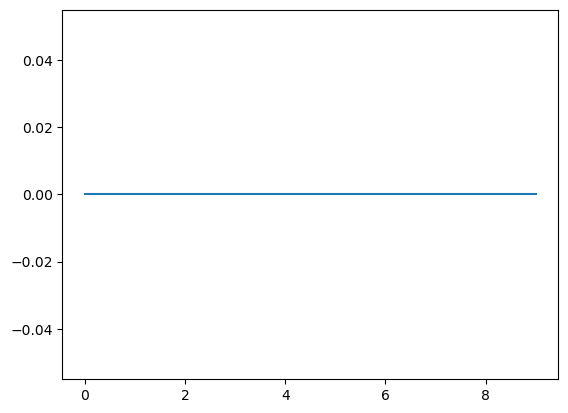

In [162]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)

In [166]:
#sample a sentence from the test set
src, tgt, src_valid_len, label = next(iter(data.shuffle(train=False, seed=0, maxi=usage_size)))

#translate the sentence

sentence = src.to(device)

tag_scores = model(sentence)

#print the original sentence
print("Original sentence : ")
for word in src[0]:
    print(token_to_word(word.item(), src=True), end=" ")
print()
for word in src[0]:
    print(word.item(), end=" ")
print()

#print the translated sentence
print("Translated sentence : ")
for word in tag_scores[0]:
    print(token_to_word(int(word.item()), src=False), end=" ")
print()
for word in tag_scores[0]:
    print(int(word.item()), end=" ")
print()

#print the target sentence
print("Target sentence : ")
for word in tgt[0]:
    print(token_to_word(word.item(), src=False), end=" ")
print()
for word in tgt[0]:
    print(word.item(), end=" ")
print()

for word in label[0]:
    print(token_to_word(word.item(), src=False), end=" ")
print()
for word in label[0]:
    print(word.item(), end=" ")
print()

3000
Original sentence : 
don't lie . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
2602 4866 72 187 188 188 188 188 188 188 188 188 188 188 188 
Translated sentence : 
3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 3000 
106 106 106 106 106 106 106 106 106 106 106 106 106 106 106 
Target sentence : 
<bos> ne mens pas . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
136 10230 9441 10939 27 137 138 138 138 138 138 138 138 138 138 
ne mens pas . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
10230 9441 10939 27 137 138 138 138 138 138 138 138 138 138 138 


To this model we can now try to add contextual embeddings

In [ ]:
#for contextual embedding we will use BERT

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

#we use bert and we will train it on the data
bert_model = BertModel.from_pretrained('bert-base-uncased')
#we will use the tokenizer to tokenize the sentences
sentences = ["I love machine learning", "I love coding in python"]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]